# D-optimal design optimization problem
### Relatively smooth optimization approach
based on the example from <a href="https://arxiv.org/pdf/1610.05708.pdf">paper 1</a> and methods from <a href="https://arxiv.org/pdf/2001.09013.pdf">paper 2</a>

In [1]:
import numpy as np
from scipy.optimize import newton, root_scalar
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.constants import golden

normalize = lambda x: x / x.sum()

In [2]:
np.random.seed(7)

m = 100
n = 120

np.fill_diagonal(H := np.random.random((m, n)) * 1e-2, np.concatenate([
    np.random.random(m // 2), np.random.random(m // 2) * 200
]))

print('m =', m, ', n =', n)
print('rank(H) =', np.linalg.matrix_rank(H))

m = 100 , n = 120
rank(H) = 100


In [3]:
h = lambda x: -np.sum(np.log(x))
dh = lambda x: -1/x

def V(y, x):
    return h(y) - h(x) - np.dot(dh(x), y - x)

In [4]:
f = lambda x: -np.linalg.slogdet(H @ np.diag(x) @ H.T)[1]
df = lambda x: -np.diag(H.T @ np.linalg.inv(H @ np.diag(x) @ H.T) @ H)

In [5]:
def solve_subproblem(c):
    th = newton(
        lambda th: np.sum(1 / (c + th)) - 1, 
        -np.min(c) + 1, 
        tol=1e-10
    )
    return 1 / (c + th)

In [6]:
x0 = normalize(np.random.random(n))

In [7]:
def optimizer(step):
    def wrapper(x, T, *args, **kwargs):
        state = defaultdict(list)
        state['x'] = x
        
        for t in range(T):
            step(state, *args, **kwargs)
        
        return len(state['f-all']), state['x'], {k: np.array(v) for k, v in state.items() if k not in ['x']}
    
    return wrapper

In [8]:
@optimizer
def gd(state, L=1):
    """
    Gradient Descent for Relatively Smooth Problems
    """
    state['f-all'].append(f(state['x']))
    state['x'] = solve_subproblem(df(state['x']) / L - dh(state['x']))

In [9]:
def golden_search(function, a, b, tol=1e-5):
    c = b - (b - a) / golden
    d = a + (b - a) / golden
    
    while abs(b - a) > tol:
        if function(c) < function(d):
            b = d
        else:
            a = c

        c = b - (b - a) / golden
        d = a + (b - a) / golden

    return (b + a) / 2

In [10]:
@optimizer
def steepest_gd(state, L=1, min_L=1e-1, relative_h_mult=0.9):
    """
    Steepest Gradient Descent for Relatively Smooth Problems
    """
    f_val = f(state['x'])
    state['f'].append(f_val)
    state['f-all'].append(f_val)
    
    def step(h):
        x_ = solve_subproblem(h * df(state['x']) - dh(state['x']))
        f_val = f(x_)
        state['f-all'].append(f_val)
        return f_val
    
    if 'h' in state:
        h0 = state['h'][-1] * relative_h_mult
    else:
        h0 = 1 / L
        
    h = golden_search(step, h0, 1 / min_L, tol=1e-1)
    state['x'] = solve_subproblem(h * df(state['x']) - dh(state['x']))
    
    if relative_h_mult is not None:
        state['h'].append(h)

In [11]:
@optimizer
def agd(state, L=1, delta=5e-9, zeta=1.7):
    """
    Adaptive Gradient Descent for Relatively Smooth Problems
    """
    f_val = f(state['x'])
    state['f'].append(f_val)
    state['f-all'].append(f_val)

    if 'L' in state:
        L = state['L'][-1]
        
    L /= zeta

    x_ = solve_subproblem(df(state['x']) / L - dh(state['x']))
    while not (f(x_) <= f(state['x']) + np.dot(df(state['x']), x_ - state['x']) + L * V(x_, state['x']) + delta):
        L *= zeta
        x_ = solve_subproblem(df(state['x']) / L - dh(state['x']))
        state['f-all'].append(f(x_))

    state['x'] = x_.copy()
    state['L'].append(L)

In [12]:
@optimizer
def steepest_agd(state, L=1, delta=5e-9, zeta=1.7):
    """
    Steepest Adaptive Gradient Descent for Relatively Smooth Problems
    """
    f_val = f(state['x'])
    state['f'].append(f_val)
    state['f-all'].append(f_val)

    if 'L' in state:
        L = state['L'][-1]
        
    L /= zeta

    x_ = solve_subproblem(df(state['x']) / L - dh(state['x']))
    while not (f(x_) <= f(state['x']) + np.dot(df(state['x']), x_ - state['x']) + L * V(x_, state['x']) + delta):
        L *= zeta
        x_ = solve_subproblem(df(state['x']) / L - dh(state['x']))
        state['f-all'].append(f(x_))

    def step(h):
        x_ = solve_subproblem(h * df(state['x']) - dh(state['x']))
        f_val = f(x_)
        state['f-all'].append(f_val)
        return f_val
    
    h = golden_search(step, 0, 1 / L, tol=1e-1)
    state['x'] = solve_subproblem(h * df(state['x']) - dh(state['x']))
    state['L'].append(1 / h)

In [13]:
@optimizer
def steepest_agd2(state, L=1, delta=5e-9, zeta=1.7):
    """
    Steepest Adaptive Gradient Descent for Relatively Smooth Problems
    """
    L0 = L
    f_val = f(state['x'])
    state['f'].append(f_val)
    state['f-all'].append(f_val)

    if 'L' in state:
        L = state['L'][-1]
        
    L /= zeta

    x_ = solve_subproblem(df(state['x']) / L - dh(state['x']))
    while not (f(x_) <= f(state['x']) + np.dot(df(state['x']), x_ - state['x']) + L * V(x_, state['x']) + delta):
        L *= zeta
        x_ = solve_subproblem(df(state['x']) / L - dh(state['x']))
        state['f-all'].append(f(x_))

    def step(h):
        x_ = solve_subproblem(h * df(state['x']) - dh(state['x']))
        f_val = f(x_)
        state['f-all'].append(f_val)
        return f_val
    
    def fit_constant(L_):
        return max(0., step(1/L_) / f(state['x']) - 0.9)
    
    if L < L0:
        L_hat = 1 / L
    else:
        if step(1/L0) > f(state['x']):
            L_hat = L0
        else:
            L_hat = None
            for a in np.linspace(1e-2, 1, 10)[::-1]:
                if step(1/(L0 * a)) > f(state['x']):
                    L_hat = L0 * a
                    break
            if L_hat is None:
                for a in np.linspace(1e-3, 1e-2, 6)[::-1]:
                    if step(1/(L0 * a)) > f(state['x']):
                        L_hat = L0 * a
                        break
        
    h = golden_search(step, 0, 1 / L_hat, tol=1e-1)
    state['x'] = solve_subproblem(h * df(state['x']) - dh(state['x']))
    state['L'].append(1 / h)

In [52]:
@optimizer
def steepest_agd3(state, L=1, delta=5e-9, zeta=1.7):
    """
    Steepest Adaptive Gradient Descent for Relatively Smooth Problems
    """
    L0 = L
    f_val = f(state['x'])
    state['f'].append(f_val)
    state['f-all'].append(f_val)

    if 'L' in state:
        L = state['L'][-1]
        
    L /= zeta

    x_ = solve_subproblem(df(state['x']) / L - dh(state['x']))
    while not (f(x_) <= f(state['x']) + np.dot(df(state['x']), x_ - state['x']) + L * V(x_, state['x']) + delta):
        L *= zeta
        x_ = solve_subproblem(df(state['x']) / L - dh(state['x']))
        state['f-all'].append(f(x_))

    def step(L):
        x_ = solve_subproblem(df(state['x']) / L - dh(state['x']))
        f_val = f(x_)
        state['f-all'].append(f_val)
        return f_val
        
    L_star = golden_search(step, 0, L, tol=1e-1)
    state['x'] = solve_subproblem(df(state['x']) / L_star - dh(state['x']))
    state['L'].append(L / zeta)

In [14]:
delta = 5e-9
zeta = 1.7

T, x_agd, state_agd = agd(x0, T=400, L=1, delta=delta, zeta=zeta)

In [15]:
_, x_gd, state_gd = gd(x0, T=T, L=1)

In [16]:
_, x_steepest_gd, state_steepest_gd = steepest_gd(
    x0, T=150, L=1, min_L=0.3, relative_h_mult=0.9
)

In [17]:
_, x_steepest_agd, state_steepest_agd = steepest_agd(
    x0, T=150, L=1, delta=delta, zeta=zeta
)

In [18]:
_, x_steepest_agd2, state_steepest_agd2 = steepest_agd2(
    x0, T=100, L=1, delta=delta, zeta=zeta
)

In [53]:
_, x_steepest_agd3, state_steepest_agd3 = steepest_agd3(
    x0, T=100, L=1, delta=delta, zeta=zeta
)

In [19]:
R = min(state_agd['L'][-1], 1 / np.sum(1 / state_agd['L'])) * V(x_agd, x0) + 3*delta
f_opt = np.min(state_agd['f-all']) - R

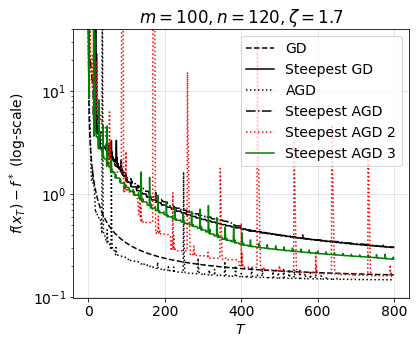

In [54]:
limit_T = min(
    state_gd['f-all'].shape[0],
    state_steepest_gd['f-all'].shape[0],
    state_agd['f-all'].shape[0],
    state_steepest_agd['f-all'].shape[0],
    state_steepest_agd2['f-all'].shape[0],
    state_steepest_agd3['f-all'].shape[0]
)

plt.figure(figsize=(6,5))
plt.rcParams.update({'font.size': 14})

plt.semilogy(state_gd['f-all'][:limit_T] - f_opt, 'k--', label='GD')
plt.semilogy(state_steepest_gd['f-all'][:limit_T] - f_opt, 'k-', label='Steepest GD')
plt.semilogy(state_agd['f-all'][:limit_T] - f_opt, 'k:', label='AGD')
plt.semilogy(state_steepest_agd['f-all'][:limit_T] - f_opt, 'k-.', label='Steepest AGD')
plt.semilogy(state_steepest_agd2['f-all'][:limit_T] - f_opt, 'r:', label='Steepest AGD 2')
plt.semilogy(state_steepest_agd3['f-all'][:limit_T] - f_opt, 'g-', label='Steepest AGD 3')

plt.grid(alpha=0.4)
plt.legend()

plt.title(f'$m = {m}, n = {n}, \zeta = {zeta}$')
plt.ylabel('$f(x_T) - f^*$ (log-scale)')
plt.ylim(top=state_agd['f'][0] - f_opt)
plt.xlabel('$T$')

plt.tight_layout()
plt.show()

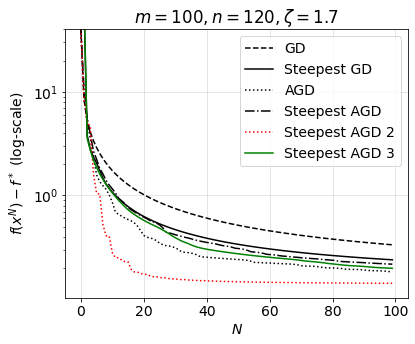

In [55]:
limit_N = min(
    state_gd['f-all'].shape[0],
    state_steepest_gd['f'].shape[0],
    state_agd['f'].shape[0],
    state_steepest_agd['f'].shape[0],
    state_steepest_agd2['f'].shape[0],
    state_steepest_agd3['f'].shape[0]
)

plt.figure(figsize=(6,5))
plt.rcParams.update({'font.size': 14})

plt.semilogy(state_gd['f-all'][:limit_N] - f_opt, 'k--', label='GD')
plt.semilogy(state_steepest_gd['f'][:limit_N] - f_opt, 'k-', label='Steepest GD')
plt.semilogy(state_agd['f'][:limit_N] - f_opt, 'k:', label='AGD')
plt.semilogy(state_steepest_agd['f'][:limit_N] - f_opt, 'k-.', label='Steepest AGD')
plt.semilogy(state_steepest_agd2['f'][:limit_N] - f_opt, 'r:', label='Steepest AGD 2')
plt.semilogy(state_steepest_agd3['f'][:limit_N] - f_opt, 'g-', label='Steepest AGD 3')



plt.grid(alpha=0.4)
plt.legend()

plt.title(f'$m = {m}, n = {n}, \zeta = {zeta}$')
plt.ylabel('$f(x^N) - f^*$ (log-scale)')
plt.ylim(top=state_agd['f'][0] - f_opt)
plt.xlabel('$N$')

plt.tight_layout()
plt.show()

In [57]:
print(f'f - f* after {limit_T} solved subproblems:\n')
print('AGD:', round(state_agd['f-all'][limit_T-1] - f_opt, 2))
print('Steepest AGD 2:', round(state_steepest_agd2['f-all'][limit_T-1] - f_opt, 2))
print('GD:', round(state_gd['f-all'][limit_T-1] - f_opt, 2))
print('Steepest AGD 3:', round(state_steepest_agd3['f-all'][limit_T-1] - f_opt, 2))
print('Steepest GD:', round(state_steepest_gd['f-all'][limit_T-1] - f_opt, 2))
print('Steepest AGD:', round(state_steepest_agd['f-all'][limit_T-1] - f_opt, 2))

f - f* after 800 solved subproblems:

AGD: 0.15
Steepest AGD 2: 0.16
GD: 0.16
Steepest AGD 3: 0.23
Steepest GD: 0.3
Steepest AGD: 0.31


In [59]:
print(f'f - f* after {limit_N} iterations:\n')
print('Steepest AGD 2:', round(state_steepest_agd2['f'][limit_N-1] - f_opt, 2))
print('AGD:', round(state_agd['f'][limit_N-1] - f_opt, 2))
print('Steepest AGD 3:', round(state_steepest_agd3['f'][limit_N-1] - f_opt, 2))
print('Steepest AGD:', round(state_steepest_agd['f'][limit_N-1] - f_opt, 2))
print('Steepest GD:', round(state_steepest_gd['f'][limit_N-1] - f_opt, 2))
print('GD:', round(state_gd['f-all'][limit_N-1] - f_opt, 2))

f - f* after 100 iterations:

Steepest AGD 2: 0.14
AGD: 0.18
Steepest AGD 3: 0.2
Steepest AGD: 0.22
Steepest GD: 0.24
GD: 0.33
